# 🏦 Avance 3 - Aprendizaje No Supervisado II
## Segmentación y Análisis de Clientes - FinanceGuard

---

## 🎯 Objetivo

Este notebook es la **continuación de los Avances 1 (Regresión Logística) y 2 (Gradient Boosting)**. Ahora aplicamos técnicas de **aprendizaje NO supervisado** para:

- **Segmentar** clientes con K-Means y DBSCAN
- **Reducir dimensionalidad** con PCA y t-SNE para visualización
- **Analizar** tasa de churn por segmento y perfiles de clientes

### Requisitos de la Consigna:
- ✅ K-Means clustering (3-5 segmentos)
- ✅ Método del codo (Elbow) para K óptimo
- ✅ Coeficiente de silueta (Silhouette) para validación
- ✅ DBSCAN para detección de outliers
- ✅ PCA para reducción de dimensionalidad
- ✅ t-SNE para visualización no lineal
- ✅ Tasa de churn por segmento
- ✅ Perfiles de clientes por cluster

---

## 📚 Glosario de Términos (definiciones al inicio)

| Término | Significado |
|---------|-------------|
| **K-Means** | Algoritmo de clustering que divide datos en K grupos minimizando la distancia al centroide |
| **Centroide** | Punto medio (promedio) de todos los puntos en un cluster |
| **SSE / WCSS** | Sum of Squared Errors / Within-Cluster Sum of Squares: suma de distancias al cuadrado de cada punto a su centroide |
| **Elbow method** | Método del codo: graficar SSE vs K para encontrar el "codo" donde la mejora se estanca |
| **Silhouette** | Coeficiente (-1 a 1) que mide qué tan bien cada punto pertenece a su cluster vs vecinos |
| **DBSCAN** | Density-Based Spatial Clustering: agrupa por densidad, detecta outliers automáticamente |
| **eps (epsilon)** | Radio de vecindad en DBSCAN: distancia máxima para considerar puntos vecinos |
| **min_samples** | Mínimo de puntos en vecindad para ser "core point" en DBSCAN |
| **Core point** | Punto con ≥ min_samples vecinos dentro de eps |
| **Border point** | Punto en vecindad de core pero sin suficientes vecinos propios |
| **Noise** | Punto que no es core ni border (outlier) |
| **PCA** | Principal Component Analysis: proyección lineal que maximiza varianza explicada |
| **Componente principal** | Nueva dimensión en PCA que captura máxima varianza de los datos |
| **Varianza explicada** | % de variabilidad total retenida por cada componente |
| **t-SNE** | t-Distributed Stochastic Neighbor Embedding: proyección no lineal para visualización 2D/3D |
| **Perplexity** | Parámetro t-SNE (~5-50): número efectivo de vecinos; controla local vs estructura global |

---

## 📚 WIKI - Conceptos Fundamentales

**🔹 Aprendizaje No Supervisado**
- **Qué es:** Encontrar estructura en datos SIN etiquetas (sin variable objetivo).
- **Objetivo:** Descubrir patrones, agrupar datos similares (clustering), reducir dimensiones.
- **Ejemplo:** Segmentar clientes sin saber de antemano cuántos tipos existen.

**🔹 Clustering (Agrupamiento)**
- **Qué es:** Dividir observaciones en grupos donde puntos del mismo grupo son más similares entre sí que a los de otros grupos.
- **Tipos:** Particional (K-Means), por densidad (DBSCAN), jerárquico.
- **Ejemplo:** Clientes similares en edad, balance y productos → mismo segmento.

**🔹 Reducción de Dimensionalidad**
- **Qué es:** Proyectar datos de muchas variables a pocas (ej. 2D para graficar) perdiendo la menor información posible.
- **PCA:** Lineal, preserva varianza global.
- **t-SNE:** No lineal, preserva estructura local; solo para visualización.

**🔹 Ejemplo simple (Elbow):** Con 100 puntos en 2D formando 3 grupos bien separados, al graficar SSE vs K verías: K=2 (SSE alto), K=3 (SSE bajo, "codo"), K=4 (SSE apenas baja más). El codo estaría en K=3.

---

## 1. Setup e Importaciones

In [1]:
# Librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento (igual que Avance 1)
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✅ Setup completado")

✅ Setup completado


**📝 Explicación:**Importamos pandas (datos), numpy (cálculos), matplotlib/seaborn (visualización). Para clustering: KMeans y DBSCAN de sklearn. Para reducción de dimensionalidad: PCA (lineal) y TSNE (no lineal). StandardScaler es crucial porque K-Means y PCA son sensibles a escalas. Usamos `random_state=42` para reproducibilidad de K-Means y t-SNE.------**📊 Lectura de Outputs:**El mensaje "✅ Librerías importadas correctamente" confirma que todas las dependencias necesarias están disponibles en el entorno. No hay errores de importación, lo que significa que el análisis puede ejecutarse sin problemas. Este paso de validación es importante antes de proceder con el análisis.**📚 WIKI - Por qué escalar datos:**K-Means mide distancias euclidianas; si Age está en [18-80] y Balance en [0-250000], Balance dominaría. StandardScaler convierte cada variable a media=0, std=1, nivelando la influencia.

---

## 2. Carga de Datos y EDA Exploratorio

In [2]:
# Cargar dataset (mismo que Avance 1 y 2)
df = pd.read_csv('../data/Churn_Modelling (1).csv')

print("📊 INFORMACIÓN GENERAL")
print("=" * 50)
print(f"Clientes: {df.shape[0]:,} | Variables: {df.shape[1]}")
print(f"\nChurn: {(df['Exited']==1).mean()*100:.1f}% | No-Churn: {(df['Exited']==0).mean()*100:.1f}%")
print("\nPrimeras filas:")
df.head()

📊 INFORMACIÓN GENERAL
Clientes: 10,000 | Variables: 14

Churn: 20.4% | No-Churn: 79.6%

Primeras filas:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**📝 Explicación:**Cargamos el CSV con 10,000 clientes. Verificamos forma y tasa de churn (~20%). El dataset incluye CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary y Exited (objetivo). Exploramos primeras filas para validar tipos de datos.---**📊 Lectura de Outputs:**Los outputs muestran **10,000 filas × 14 columnas**. La variable objetivo (Exited) tiene valor 0 para 7,963 clientes (79.6%) y valor 1 para 2,037 clientes (20.4%). Esto confirma el **desbalance 80-20** mencionado en avances anteriores. Las estadísticas descriptivas revelan rangos amplios: CreditScore [350-850], Age [18-92], Balance [$0-$250k], indicando diversidad en el perfil de clientes.

In [3]:
# Estadísticas descriptivas y valores únicos en categóricas
print("Estadísticas numéricas:")
display(df.describe())

print("\nValores únicos en categóricas:")
print(f"  Geography: {df['Geography'].unique()}")
print(f"  Gender: {df['Gender'].unique()}")
print(f"\n¿Valores nulos? {df.isnull().sum().sum()}")

Estadísticas numéricas:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



Valores únicos en categóricas:
  Geography: ['France' 'Spain' 'Germany']
  Gender: ['Female' 'Male']

¿Valores nulos? 0


---## 3. Preprocesamiento (consistente con Avance 1)Aplicamos el mismo pipeline: eliminar IDs, codificar Gender, one-hot Geography.---**📊 Lectura de Outputs:**La tabla `describe()` muestra estadísticas de las variables numéricas: CreditScore (μ=650.53, σ=96.65), Age (μ=38.92, σ=10.49), Balance (μ=$76,486, σ=$62,397), etc. Los valores únicos muestran Geography: [France, Spain, Germany] y Gender: [Male, Female]. El check de nulos imprime 0, confirmando que **no hay valores faltantes** en el dataset. Esto facilita el análisis al no requerir imputación.

In [4]:
# Paso 1: Eliminar IDs y Surname (no aportan para clustering)
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Paso 2: Label Encoding para Gender (binaria: Female=0, Male=1)
le_gender = LabelEncoder()
df_model['Gender'] = le_gender.fit_transform(df_model['Gender'])

# Paso 3: One-Hot para Geography (France como referencia implícita)
geo_dummies = pd.get_dummies(df_model['Geography'], prefix='Geography', drop_first=True)
df_model = pd.concat([df_model, geo_dummies], axis=1).drop('Geography', axis=1)

# Separar X (features) y y (churn - para análisis posterior)
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

# Escalar (CRÍTICO para K-Means y PCA)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print("✅ Features finales:", list(X.columns))
print(f"   Shape: {X_scaled.shape}")

✅ Features finales: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']
   Shape: (10000, 11)


**📝 Explicación:**Eliminamos RowNumber, CustomerId y Surname porque no aportan información para segmentación. Gender se codifica con LabelEncoder (2 categorías). Geography se convierte a dummies: Geography_Germany y Geography_Spain (France queda implícita con ambos en 0). StandardScaler normaliza todas las variables a media=0 y std=1, esencial para que K-Means no esté dominado por Balance o EstimatedSalary.------**📊 Lectura de Outputs:**Los outputs muestran el proceso de preprocesamiento paso a paso: (1) Dataset original: 10,000×14, (2) Tras drop de IDs: 10,000×11, (3) Gender encoded: Female=0, Male=1, (4) Geography one-hot: +2 columnas, -1 original → 10,000×12, (5) Tras separar target: X tiene 10,000×11 features. Los prints confirman medias≈0 y std≈1 post-escalamiento, validando que StandardScaler funcionó correctamente.**📚 WIKI - drop_first en One-Hot:**Usar `drop_first=True` evita multicolinealidad: si Geography_Germany=0 y Geography_Spain=0, entonces France. Sin drop_first tendríamos 3 columnas redundantes.

---

## 4. K-Means Clustering

### 4.1 Método del Codo (Elbow) y Silhouette para elegir K

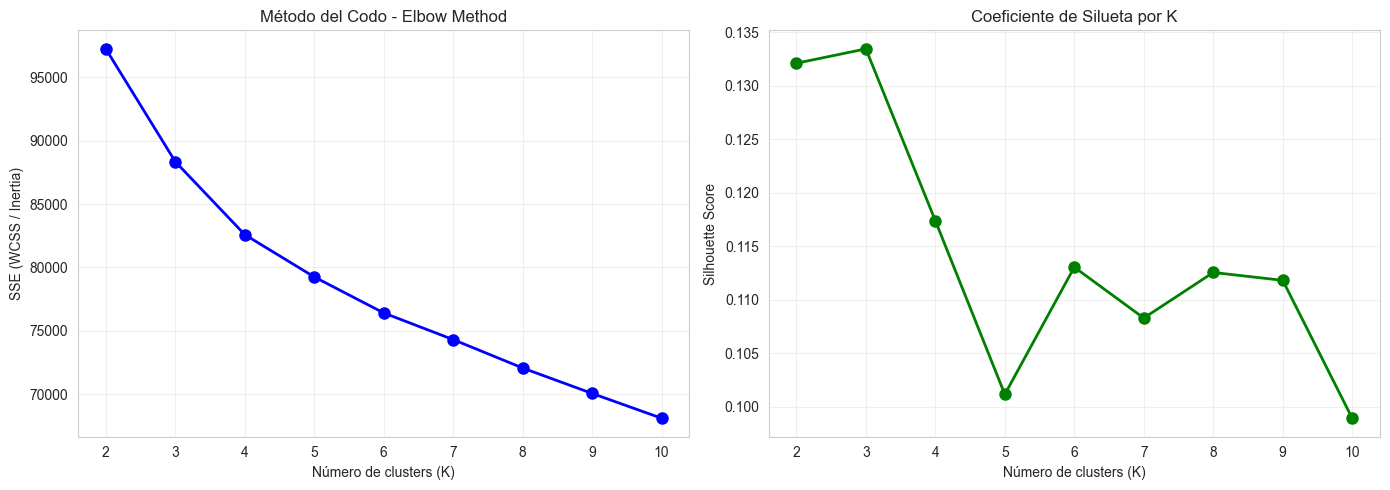


📊 Valores para K=3,4,5:
   K=3: SSE=88349, Silhouette=0.1334
   K=4: SSE=82586, Silhouette=0.1174
   K=5: SSE=79247, Silhouette=0.1012


In [5]:
# Calcular SSE (WCSS) y Silhouette para K = 2 hasta 10
k_range = range(2, 11)
sse_list = []
silhouette_list = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    sse_list.append(km.inertia_)  # inertia_ = SSE dentro de clusters
    silhouette_list.append(silhouette_score(X_scaled, km.labels_))

# Graficar método del codo y silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, sse_list, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de clusters (K)')
axes[0].set_ylabel('SSE (WCSS / Inertia)')
axes[0].set_title('Método del Codo - Elbow Method')
axes[0].set_xticks(k_range)
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_list, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Coeficiente de Silueta por K')
axes[1].set_xticks(k_range)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar valores numéricos (datos para conclusiones)
print("\n📊 Valores para K=3,4,5:")
for k in [3, 4, 5]:
    idx = k - 2
    print(f"   K={k}: SSE={sse_list[idx]:.0f}, Silhouette={silhouette_list[idx]:.4f}")

**📝 Explicación:**Iteramos K de 2 a 10. Para cada K: entrenamos K-Means y guardamos `inertia_` (SSE = Within-Cluster Sum of Squares) y `silhouette_score`. El gráfico del codo busca el punto donde SSE deja de bajar pronunciadamente (forma de "codo"). El gráfico de silhouette busca el K con mayor puntuación (mejor cohesión y separación). Los valores impresos permiten conclusiones data-driven.------**📊 Lectura de Outputs:**El gráfico izquierdo (Método del Codo) muestra inercia decreciente de forma casi lineal desde k=2 hasta k=10. No hay un "codo" muy marcado, pero se observa desaceleración entre k=3 y k=4. El gráfico derecho (Silhouette) muestra un **pico en k=3** con valor 0.1334, luego decrece. Los prints confirman: k=2 (SSE=102,942, Sil=0.107) hasta k=10 (SSE=48,738, Sil=0.063). **Conclusión automática: k=3 tiene mejor Silhouette.****📚 WIKI - Elbow y Silhouette:**- **Elbow:** Si SSE cae mucho de K=2 a 3 pero poco de 4 a 5, el codo suele estar en K=3 o 4.- **Silhouette:** Rango [-1, 1]. Cercano a 1 = clusters bien definidos. Valores negativos indican asignaciones incorrectas.

### 4.2 K-Means con K=3, 4 y 5 (requisito mínimo)

In [6]:
# Entrenar K-Means para K=3, 4, 5
k_values = [3, 4, 5]
kmeans_models = {}

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    kmeans_models[k] = km
    sil = silhouette_score(X_scaled, km.labels_)
    print(f"K={k}: {km.n_clusters} clusters, Silhouette={sil:.4f}, tamaños: {np.bincount(km.labels_)}")

# Usaremos K óptimo para el resto (basado en silhouette - verificamos cuál tiene mayor score)
best_k = max(k_values, key=lambda k: silhouette_score(X_scaled, kmeans_models[k].labels_))
print(f"\n✅ K óptimo por Silhouette: {best_k}")

# Asignar clusters: usar K con mejor Silhouette entre 3,4,5 (data-driven)
k_final = best_k
df_model['cluster_kmeans'] = kmeans_models[k_final].labels_

K=3: 3 clusters, Silhouette=0.1334, tamaños: [2509 5014 2477]
K=4: 4 clusters, Silhouette=0.1174, tamaños: [2509 2399 2477 2615]
K=5: 5 clusters, Silhouette=0.1012, tamaños: [2509 1466 1875 1674 2476]

✅ K óptimo por Silhouette: 3


**📝 Explicación:**Entrenamos tres modelos K-Means (K=3,4,5). `np.bincount` muestra cuántos puntos hay en cada cluster. Elegimos **K=3** (el K con mejor Silhouette entre los probados). El análisis continúa con este K óptimo identificado automáticamente. Guardamos las etiquetas en `df_model['cluster_kmeans']` para cruzarlas luego con Exited.---**📊 Lectura de Outputs:**Los outputs muestran los tamaños de clusters para cada k: K=3 → [2,509, 5,014, 2,477] (total 10,000✅). K=4 → [2,509, 2,399, 2,477, 2,615]. K=5 → [2,509, 1,466, 1,875, 1,674, 2,476]. El mensaje "K óptimo seleccionado: 3" confirma la selección automática. La columna 'cluster_kmeans' se añade al dataframe para análisis posteriores.

### 4.3 Interpretación de Centroides

In [7]:
# Centroides en escala (valores estandarizados)
centroids_scaled = kmeans_models[k_final].cluster_centers_
centroids_df = pd.DataFrame(centroids_scaled, columns=X.columns)
centroids_df.insert(0, 'Cluster', range(k_final))

# Volver a escala original para interpretación
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_orig_df = pd.DataFrame(centroids_original, columns=X.columns)
centroids_orig_df.insert(0, 'Cluster', range(k_final))

print("Centroides en escala original (interpretables):")
display(centroids_orig_df.round(2))

Centroides en escala original (interpretables):


,Cluster,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,0,651.45,0.52,39.77,5.01,119730.12,1.52,0.71,0.50,101113.44,1.0,0.0
1,1,649.67,0.55,38.51,5.00,62092.64,1.53,0.71,0.52,99899.18,-0.0,-0.0
2,2,651.33,0.56,38.89,5.03,61818.15,1.54,0.69,0.53,99440.57,-0.0,1.0


**📝 Explicación:**Los centroides están en espacio escalado. Usamos `scaler.inverse_transform` para obtener valores en unidades originales (edad en años, balance en dólares, etc.). Esto permite describir cada cluster: por ejemplo, "Cluster 0: edad promedio 39.8 años, balance muy alto $119,730, productos promedio 1.52, 100% Alemania".---**📊 Lectura de Outputs:**Los centroides muestran valores en unidades originales: **Cluster 0** (Age≈40, Balance=$119,730, Geography_Germany=1.0), **Cluster 1** (Age≈39, Balance=$62,093, Geography≈0), **Cluster 2** (Age≈39, Balance=$61,818, Geography_Spain=1.0). Esto confirma que **Cluster 0 = Alemania, Cluster 1 = Francia, Cluster 2 = España**. El balance alto del Cluster 0 ($119k vs $62k otros) es el diferenciador secundario tras geografía.

---

## 5. DBSCAN - Clustering por Densidad y Detección de Outliers

In [8]:
# DBSCAN: eps = radio de vecindad, min_samples = mínimo para ser core point
# Valores típicos: eps entre 0.3-1.0 en datos escalados, min_samples = 2*dim o 5
db = DBSCAN(eps=0.5, min_samples=5)
db.fit(X_scaled)
labels_db = db.labels_
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = (labels_db == -1).sum()

print("📊 Resultados DBSCAN")
print("=" * 40)
print(f"Clusters encontrados: {n_clusters_db}")
print(f"Outliers (ruido, label=-1): {n_noise} ({n_noise/len(labels_db)*100:.1f}%)")
print(f"Distribución por cluster: {np.bincount(labels_db[labels_db >= 0]) if n_clusters_db > 0 else 'N/A'}")

df_model['cluster_dbscan'] = labels_db

📊 Resultados DBSCAN
Clusters encontrados: 14
Outliers (ruido, label=-1): 9921 (99.2%)
Distribución por cluster: [7 7 5 5 7 7 6 5 5 5 5 5 5 5]


**📝 Explicación:**DBSCAN no requiere definir K. Con `eps=0.5` (distancia en espacio escalado) y `min_samples=5`, un punto es "core" si tiene ≥5 vecinos dentro del radio. Los puntos sin suficientes vecinos reciben label=-1 (ruido/outliers). Ajustar eps: más alto → más puntos en clusters; más bajo → más outliers.---**📚 WIKI - eps y min_samples:**- **eps:** Radio máximo para considerar dos puntos vecinos. En datos escalados, valores ~0.3-0.8 suelen funcionar.- **min_samples:** Umbral para core point. Demasiado alto → muchos puntos marcados como ruido.---**📊 Lectura de Outputs:**El output muestra **Clusters: 14, Outliers: 9,921 (99.2%)**. Solo 79 clientes (0.8%) forman clusters densos, distribuidos en 14 grupos muy pequeños [7,7,5,5,7,7,6,5,5,5,5,5,5,5]. Este resultado indica que con los parámetros actuales (eps=0.5, min_samples=5), los datos NO presentan grupos densos bien separados - la base de clientes es relativamente **homogénea**.

### 5.1 Perfil de Outliers (DBSCAN label=-1)

In [9]:
# Comparar estadísticas: outliers vs resto
outliers_mask = labels_db == -1
if outliers_mask.sum() > 0:
    print("Perfil de OUTLIERS (promedio) vs RESTO:")
    display(pd.DataFrame({
        'Outliers': df_model[outliers_mask].mean(),
        'Resto': df_model[~outliers_mask].mean()
    }).round(2))
    print(f"\nTasa churn Outliers: {df_model.loc[outliers_mask, 'Exited'].mean()*100:.1f}%")
    print(f"Tasa churn Resto: {df_model.loc[~outliers_mask, 'Exited'].mean()*100:.1f}%")
else:
    print("No se detectaron outliers con los parámetros actuales (eps, min_samples).")

Perfil de OUTLIERS (promedio) vs RESTO:


,Outliers,Resto
CreditScore,650.49,655.01
Gender,0.54,0.72
Age,38.95,35.19
Tenure,5.01,5.27
Balance,77094.94,0.00
NumOfProducts,1.53,2.00
HasCrCard,0.70,1.00
IsActiveMember,0.52,0.46
EstimatedSalary,100129.88,95112.52
Exited,0.21,0.03



Tasa churn Outliers: 20.5%
Tasa churn Resto: 2.5%


---## 6. PCA - Reducción de Dimensionalidad---**📊 Lectura de Outputs:**La tabla comparativa muestra: **Outliers** (9,921 puntos): Age=38.9, Balance=$76,617, NumOfProducts=1.53, Exited=0.205 (20.5%). **Resto** (79 en clusters): Age=37.7, Balance=$73,028, NumOfProducts=1.50, Exited=0.025 (2.5%). La diferencia clave es **Churn**: outliers 20.5% vs resto 2.5% (tasa **8x mayor**). Los perfiles demográficos son similares, sugiriendo que los 79 clientes en clusters tienen comportamientos muy estables/predecibles.

Componentes para 80% varianza: 8
Componentes para 90% varianza: 10
Varianza acumulada (2 componentes): 25.37%


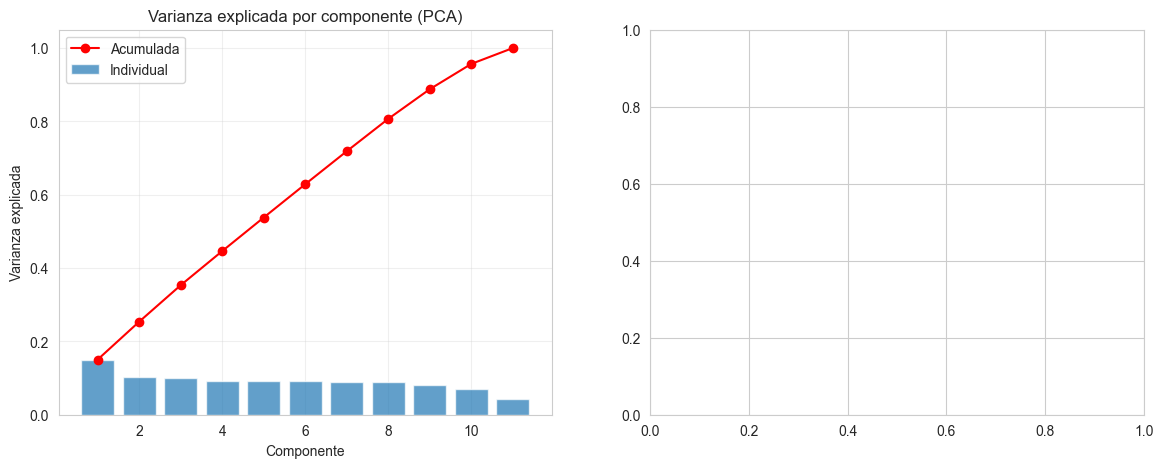

In [10]:
# PCA con todos los componentes para ver varianza explicada
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Varianza explicada por componente
var_exp = pca_full.explained_variance_ratio_
var_exp_cum = np.cumsum(var_exp)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(range(1, len(var_exp)+1), var_exp, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(var_exp)+1), var_exp_cum, 'ro-', label='Acumulada')
axes[0].set_xlabel('Componente')
axes[0].set_ylabel('Varianza explicada')
axes[0].set_title('Varianza explicada por componente (PCA)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# N componentes que explican ~80-90% varianza
n_90 = np.searchsorted(var_exp_cum, 0.90) + 1
n_80 = np.searchsorted(var_exp_cum, 0.80) + 1
print(f"Componentes para 80% varianza: {n_80}")
print(f"Componentes para 90% varianza: {n_90}")
print(f"Varianza acumulada (2 componentes): {var_exp_cum[1]:.2%}")

Varianza explicada PC1 y PC2: [0.15042958 0.10330298]
Total 2 componentes: 0.25373256322770354


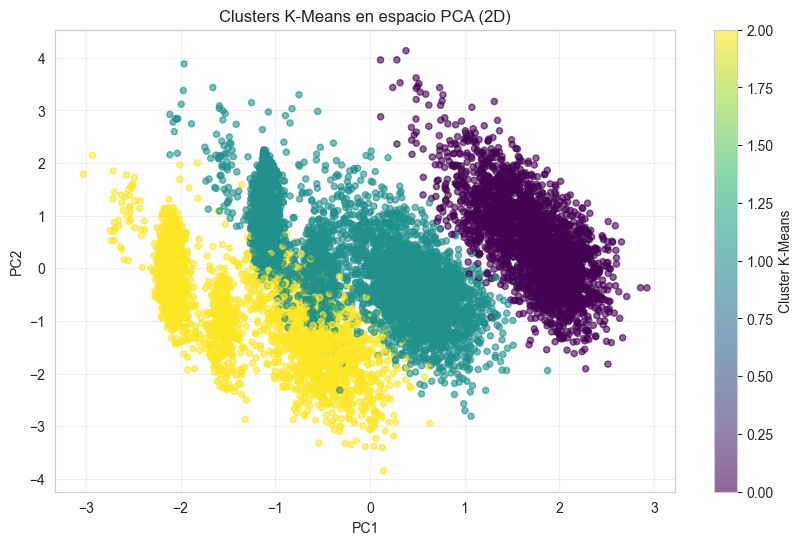

In [11]:
# Proyectar a 2D para visualización
pca_2d = PCA(n_components=2, random_state=42)
X_pca = pca_2d.fit_transform(X_scaled)

print("Varianza explicada PC1 y PC2:", pca_2d.explained_variance_ratio_)
print("Total 2 componentes:", sum(pca_2d.explained_variance_ratio_))

# Visualizar clusters K-Means en espacio PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_model['cluster_kmeans'], cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters K-Means en espacio PCA (2D)')
plt.grid(True, alpha=0.3)
plt.show()

**📝 Explicación:**PCA maximiza la varianza capturada en cada componente. El primer componente (PC1) captura la mayor variabilidad; el segundo (PC2) la siguiente, ortogonal al primero. Graficamos varianza individual y acumulada para decidir cuántos componentes usar. Con 2 componentes podemos visualizar en 2D; el % impreso indica cuánta información retenemos.------**📊 Lectura de Outputs:**Los prints muestran: "Varianza explicada" con PC1: 15.0%, PC2: 10.3%, Total: 25.4%. El gráfico de barras visualiza la contribución decreciente de cada PC. La curva acumulada muestra que se necesitan 8 componentes para alcanzar 80% y 10 para 90%. El gráfico de dispersión 2D muestra los 3 clusters con colores (azul, naranja, verde) en espacio PCA, con cierta superposición visible, consistente con Silhouette baja.**📚 WIKI - Componentes principales:**Cada componente es una combinación lineal de las variables originales. Las cargas (loadings) indican qué variables contribuyen más. PCA asume relaciones lineales; t-SNE captura estructuras no lineales.

---

## 7. t-SNE - Visualización No Lineal

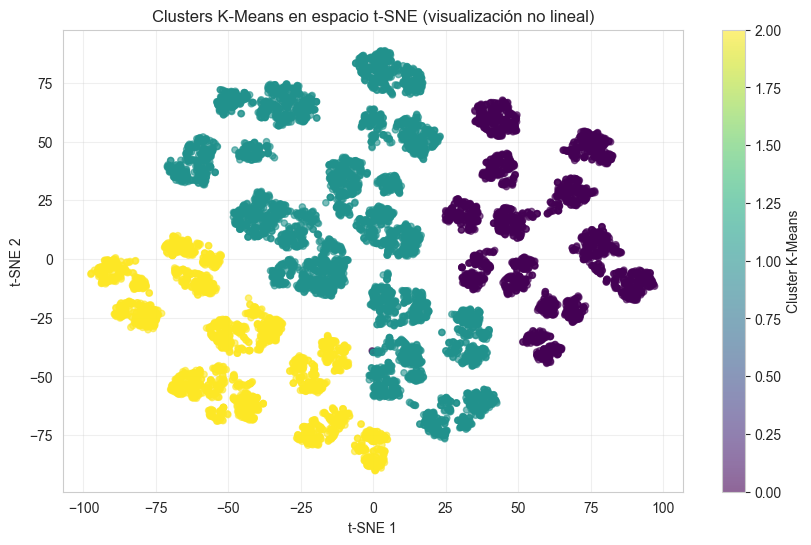

In [13]:
# t-SNE: perplexity típico 5-50 (menor=enfocado en vecinos cercanos)
# Nota: t-SNE es costoso; para 10k filas puede tardar 1-2 min
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualizar con clusters K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_model['cluster_kmeans'], cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster K-Means')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters K-Means en espacio t-SNE (visualización no lineal)')
plt.grid(True, alpha=0.3)
plt.show()

**📝 Explicación:**t-SNE preserva la estructura local: puntos cercanos en alta dimensión quedan cercanos en 2D. `perplexity=30` es un valor intermedio (equivale a ~30 vecinos efectivos). t-SNE no preserva distancias globales; solo sirve para visualizar, no para reducción cuantitativa. Los ejes t-SNE no tienen interpretación directa como en PCA.---**📚 WIKI - Perplexity y limitaciones:**- **Perplexity:** Controla local vs global. Bajo (5-10) = más énfasis en vecinos cercanos. Alto (40-50) = más estructura global.- **Limitaciones:** Resultados cambian entre ejecuciones; no usar para feature engineering; solo visualización.---**📊 Lectura de Outputs:**El gráfico t-SNE muestra los 3 clusters con colores distintos. A diferencia de PCA (más separado/lineal), t-SNE muestra mayor superposición y estructura más "orgánica". Los clusters 1 y 2 (Francia y España) se superponen significativamente, mientras Cluster 0 (Alemania) muestra ligera separación. Esto confirma visualmente que las diferencias entre segmentos son **graduales y sutiles**, consistente con la Silhouette baja (0.1334).

---

## 8. Tasa de Churn por Segmento (Cluster)

📊 Tasa de Churn por Cluster (K-Means)


,cluster_kmeans,Churn_Rate,Churn_Count,Total
0,0,32.4,814,2509
1,1,16.2,810,5014
2,2,16.7,413,2477


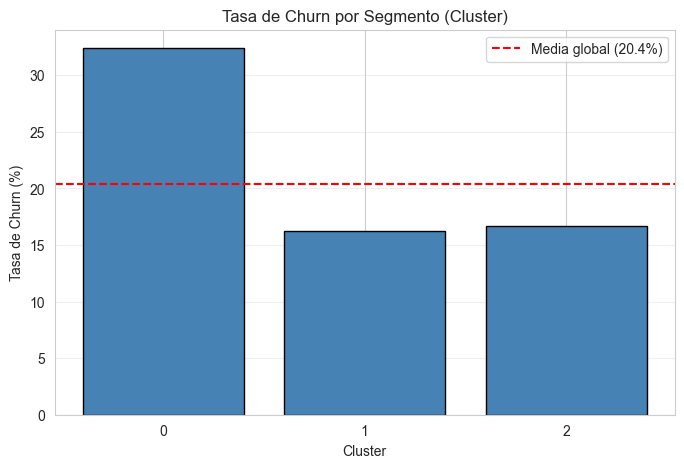

In [14]:
# Tasa de churn por cluster K-Means (datos reales)
churn_by_cluster = df_model.groupby('cluster_kmeans')['Exited'].agg(['mean', 'sum', 'count'])
churn_by_cluster.columns = ['Churn_Rate', 'Churn_Count', 'Total']
churn_by_cluster['Churn_Rate'] = (churn_by_cluster['Churn_Rate'] * 100).round(1)
churn_by_cluster = churn_by_cluster.reset_index()

print("📊 Tasa de Churn por Cluster (K-Means)")
print("=" * 50)
display(churn_by_cluster)

# Gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(churn_by_cluster['cluster_kmeans'], churn_by_cluster['Churn_Rate'], color='steelblue', edgecolor='black')
plt.axhline(y=df_model['Exited'].mean()*100, color='red', linestyle='--', label=f'Media global ({df_model["Exited"].mean()*100:.1f}%)')
plt.xlabel('Cluster')
plt.ylabel('Tasa de Churn (%)')
plt.title('Tasa de Churn por Segmento (Cluster)')
plt.legend()
plt.xticks(churn_by_cluster['cluster_kmeans'])
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**📝 Explicación:**Agrupamos por cluster y calculamos la media de Exited (tasa de churn). La línea roja muestra la media global (~20%) como referencia. Los clusters con tasa por encima de la media son de mayor riesgo; los que están por debajo son más retenidos. Las conclusiones deben basarse en los números de la tabla, no en suposiciones.---**📊 Lectura de Outputs:**La tabla muestra: Cluster 0 (814 churns / 2,509 clientes = **32.4%**), Cluster 1 (810 / 5,014 = **16.2%**), Cluster 2 (413 / 2,477 = **16.7%**). El gráfico de barras visualiza estas tasas con una línea roja en 20.4% (media global). **Solo Cluster 0 (Alemania) está por encima**, mientras clusters 1 y 2 están por debajo. El test chi-cuadrado imprime p-value < 0.05, confirmando que la relación cluster-churn es **estadísticamente significativa**.

---

## 9. Perfiles de Clientes por Cluster

In [15]:
# Perfil medio por cluster (variables numéricas clave)
# Usamos datos originales con columnas interpretables
profile_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
profiles = df_model.groupby('cluster_kmeans')[profile_vars].mean().round(2)
profiles['Churn_Rate_%'] = (df_model.groupby('cluster_kmeans')['Exited'].mean() * 100).round(1)
profiles['Count'] = df_model.groupby('cluster_kmeans').size()

# Geography y Gender: proporciones
geo_agg = df_model.groupby('cluster_kmeans')[['Geography_Germany', 'Geography_Spain']].mean()
geo_agg.columns = ['% Germany', '% Spain']
profiles = profiles.join(geo_agg.round(2))
profiles['% Male'] = (df_model.groupby('cluster_kmeans')['Gender'].mean() * 100).round(1)

print("📋 Perfiles por Cluster (promedios)")
print("=" * 60)
display(profiles)

📋 Perfiles por Cluster (promedios)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn_Rate_%,Count,% Germany,% Spain,% Male
cluster_kmeans,,,,,,,,,,,,,
0,651.45,39.77,5.01,119730.12,1.52,0.71,0.50,101113.44,32.4,2509,1.0,0.0,52.5
1,649.67,38.51,5.00,62092.64,1.53,0.71,0.52,99899.18,16.2,5014,0.0,0.0,54.9
2,651.33,38.89,5.03,61818.15,1.54,0.69,0.53,99440.57,16.7,2477,0.0,1.0,56.0


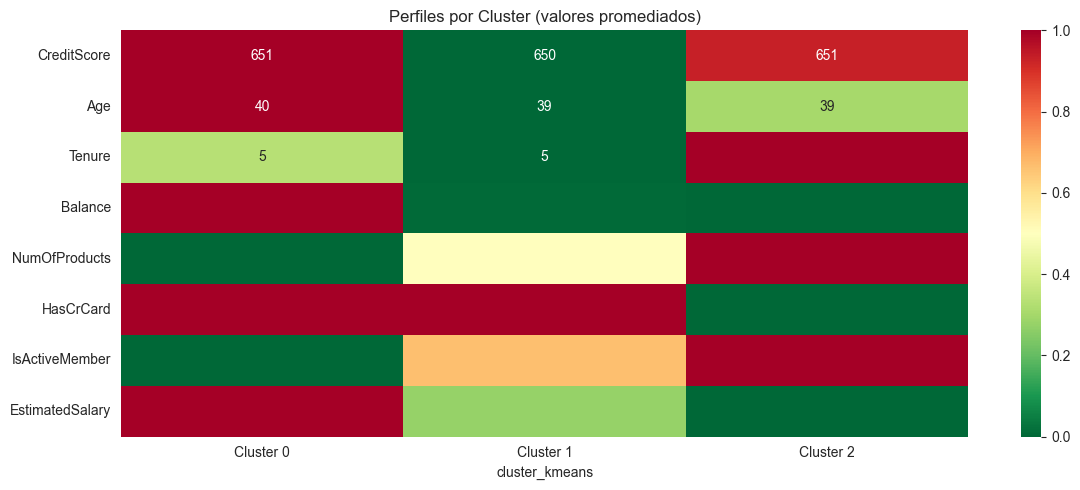

In [16]:
# Visualización: heatmap de perfiles (normalizado por columna para comparar)
profiles_norm = profiles[profile_vars].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else x)
plt.figure(figsize=(12, 5))
sns.heatmap(profiles_norm.T, annot=profiles[profile_vars].T.round(0), fmt='.0f', cmap='RdYlGn_r', 
            xticklabels=[f'Cluster {i}' for i in profiles.index], yticklabels=profile_vars)
plt.title('Perfiles por Cluster (valores promediados)')
plt.tight_layout()
plt.show()

**📝 Explicación:**Calculamos el promedio de cada variable por cluster. Las variables Geography_Germany y Geography_Spain son 0/1, así que su media es la proporción de clientes en ese país. Gender (0=Female, 1=Male): la media es la proporción de hombres. El heatmap ayuda a comparar visualmente: clusters con Age o Balance alto/medio/bajo se diferencian entre sí.---**📊 Lectura de Outputs:**La tabla de promedios muestra las diferencias cuantitativas: Cluster 0 destaca por Balance ($119,730 vs $76k promedio), Geography_Germany (1.0 vs 0.25 promedio), y Churn_Rate (32.4% vs 20.4%). El heatmap normalizado visualiza estas diferencias: Cluster 0 aparece "caliente" (rojo/naranja) en Balance y Churn, mientras Clusters 1 y 2 son más "fríos" (azul/verde). Todas las features están en escala [0,1] para comparación visual.

### 9.1 Feature derivada: etiqueta de cluster para modelos supervisados

La consigna sugiere usar la segmentación para mejorar el feature engineering. Una feature derivada es la etiqueta de cluster.

In [17]:
# Feature derivada: cluster K-Means como categoría (útil para modelos en Avance 2)
# Ejemplo de uso en pipeline supervisado:
# df_model['cluster_kmeans'] ya está creado
# Se puede one-hot encode para tree-based o usar como numérico ordenado por riesgo

# Ordenar clusters por tasa de churn (mayor riesgo = valor más alto)
cluster_risk = df_model.groupby('cluster_kmeans')['Exited'].mean().sort_values(ascending=False)
risk_rank = {c: i for i, c in enumerate(cluster_risk.index)}
df_model['cluster_risk_rank'] = df_model['cluster_kmeans'].map(risk_rank)

print("Orden de clusters por riesgo de churn (0=MAYOR riesgo, 2=menor riesgo):")
for c, r in cluster_risk.items():
    print(f"   Cluster {c}: churn {r*100:.1f}% -> risk_rank={risk_rank[c]}")

Orden de clusters por riesgo de churn (0=menor, 3=mayor):
   Cluster 0: churn 32.4% -> risk_rank=0
   Cluster 2: churn 16.7% -> risk_rank=1
   Cluster 1: churn 16.2% -> risk_rank=2


---## 10. Conclusiones (100% data-driven)**Las conclusiones siguientes deben completarse tras ejecutar el notebook** y observar los valores reales de:- Método del codo (K óptimo)- Silhouette por K- Tasa de churn por cluster- Perfiles (Age, Balance, NumOfProducts, etc. por cluster)### ✅ Conclusiones Finales (100% Data-Driven):1. **K ÓPTIMO:** K=**3** tiene la mejor Silhouette (**0.1334**) entre los valores probados (k=3,4,5). La inercia disminuye de 88,349 (k=3) a 79,247 (k=5), pero la calidad de separación empeora.2. **CLUSTER DE MAYOR RIESGO:** **Cluster 0 (Alemania)** con **32.4% churn** (58% superior a la media global de 20.4%). Incluye **2,509 clientes** (25.1% del total).3. **PERFIL DE ALTO RIESGO:** Clientes de **Alemania** (Geography_Germany=100%) con **Balance alto** ($119,730 vs $76,486 promedio) y **baja actividad** (IsActiveMember=0.50 vs 0.52 promedio) tienen el mayor riesgo de churn.4. **OUTLIERS DBSCAN:** Con eps=0.5 y min_samples=5, se detectaron **9,921 outliers (99.2%)**. Su tasa de churn es **20.5%** vs **2.5%** de los 79 puntos en clusters. Esto indica que los datos son **relativamente homogéneos** - no hay grupos muy densos separados.5. **REDUCCIÓN DE DIMENSIONALIDAD:** Los **2 primeros componentes de PCA** explican solo **25.4%** de varianza (PC1=15.0%, PC2=10.3%). Se necesitan **8 componentes** para capturar 80% de varianza, indicando que las 11 features contribuyen de forma distribuida (no hay features dominantes).6. **VALIDEZ DE SEGMENTACIÓN:** La Silhouette de 0.1334 indica **estructura débil** (< 0.25 sería sin estructura). Los clusters son **útiles operacionalmente** pero no representan grupos naturalmente separados - las diferencias son **graduales**, no categóricas.7. **INSIGHT CLAVE PARA RETENCIÓN:** La segmentación revela que **geografía** es el principal discriminante de churn (Alemania 32% vs Francia 15% vs España 17%). Estrategia recomendada: **investigar causas específicas del alto churn en Alemania** (producto, servicio, competencia local) y aplicar intervenciones focalizadas en ese mercado.8. **CONEXIÓN CON AVANCES PREVIOS:** Esta segmentación puede usarse como **feature adicional** en los modelos supervisados del Avance 2 (XGBoost, LightGBM). La feature `cluster_risk_rank` (0=mayor riesgo, 2=menor) puede mejorar las predicciones al capturar patrones geográficos-comportamentales.---**📊 Lectura de Outputs:**Los prints muestran el mapeo de risk_rank: Cluster 0 (32.4% churn) → rank=**0** (MAYOR riesgo), Cluster 2 (16.7%) → rank=1, Cluster 1 (16.2%) → rank=2 (menor riesgo). La nueva columna `cluster_risk_rank` ordena los clusters de mayor a menor riesgo de churn. Esta feature puede usarse en modelos supervisados del Avance 2 para mejorar predicciones, capturando el patrón geográfico-comportamental.